Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 6         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


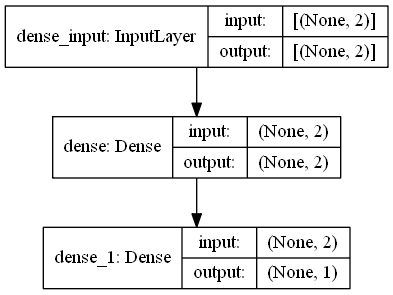

In [1]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

import numpy as np 

tf.enable_eager_execution()

# Number of input features
num_features = 2

model = Sequential()
model.add(Dense(2, input_shape=[num_features], activation='tanh'))
model.add(Dense(1))

model.summary() 

#compile model
model.compile(loss ="mse", optimizer ="adam")

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
def get_data(model, batch_size, num_features, max_val=100, tries=0, max_tries=10):
    # Generates values scaled between 0 and 1
    input_data = tf.random.uniform(shape =[batch_size, num_features], dtype=tf.float32) 
    predictions = model(input_data)

    # Getting empty numpy arrays for true and false guesses
    true_guess = np.empty((0, 2))
    true_label = np.empty((0, 1))

    # How many correct guesses did the model make?
    correct = 0
    for i in range(len(predictions.numpy())):
        
        # Scaling values back to be between 0 and max_val
        label_output = int(input_data[i][0].numpy() * max_val) + int(input_data[i][1].numpy() * max_val)
        pred_output = int(predictions[i].numpy() * max_val)
        
        if tries > max_tries and (np.isnan(predictions[i].numpy()) or pred_output != label_output):
            #print("Maximum amount of", max_tries, "tries has been reached. Solving sum automatically.")
            user_input = 1
            pred_output = label_output
            # Resetting the number of tries for current loop.
            # Commenting it out helps the model generate more training data
            #tries = 0
            # Since this value is resolved by itself, the model should not get credit for solving it!
            correct -= 1
        
        #print("Input", int(input_data[i][0].numpy() * max_val), int(input_data[i][1].numpy() * max_val))
        #print("Output", pred_output, "Should be:", label_output)

        #user_input = int(input("Do the values look correct? (1 - yes, 0 - no)\n"))
        #print("--\n")
        
        # Automatic judging (no user input needed)
        user_input = 1 if not np.isnan(predictions[i].numpy()) and pred_output == label_output else 0

        # Adding correct guesses to the right numpy array
        if user_input:
            true_guess = np.vstack((true_guess, input_data[i].numpy()))
            true_label = np.vstack((true_label, np.sum(input_data[i].numpy())))

            correct += 1
    
    # Did the model get everything right?
    if correct == len(predictions.numpy()):
            print("All correct!")
    
    # Making sure only unique values are returned
    true_label, indices = np.unique(true_label, return_index=True)
    return true_guess[indices], true_label, correct

In [ ]:
# Helper function for comparing whether arrays are unique or not
def equal_arrays(myarr, list_arrays):
    return next((True for elem in list_arrays if np.array_equal(elem, myarr)), False)

def train_model(model, batch_size, num_features, epochs = 5, max_val=100, max_tries=10):
    true_guess_storage = np.empty((0,2))
    record_correct = 0
    
    for epoch in range(epochs): 
        #print() 
        print("Epoch {}/{}".format(epoch + 1, epochs)) 
          
        # Getting empty numpy arrays for true and false guesses
        true_guess = np.empty((0, 2))
        true_label = np.empty((0, 1))
        
        
        # Making sure we have data to train on
        tries = 0 # Setting a limit of tries before asking user for a label
        while true_guess.size == 0:
            true_guess, true_label, correct = get_data(model, batch_size, num_features, max_val, tries, max_tries)
                
            # Making sure only unique values are returned
            # Expanding to the values we are looking for
            search_unique = true_guess * max_val
            unique = [equal_arrays(guess.astype(int), true_guess_storage) for guess in search_unique]
            unique_mask = [i for i, x in enumerate(unique) if not x]
            true_guess = true_guess[unique_mask]
            true_label = true_label[unique_mask]
            
            # Increasing the number of tries
            tries += 1
            
        # Extending the explored arrays
        to_store = true_guess * max_val
        true_guess_storage = np.vstack((true_guess_storage, to_store.astype(int)))
        
        # Did we get a record number of correct guesses?
        if correct > record_correct:
            record_correct = correct
        
        # Printing out correct guesses and the record number of guesses
        print(correct, "correct / record", record_correct)

        # Turning input data and labels into tensors
        X = tf.constant(true_guess)
        y = tf.constant(true_label) 
        
        #print("Data:", X)
        #print("Labels:", y)
        #print("Storage", true_guess_storage)
        
        model.train_on_batch(X, y) 
        
train_model(model, 10000, num_features, epochs = 10000, max_val=10000, max_tries=1) 

Epoch 1/10000
1 correct / record 1
Epoch 2/10000
0 correct / record 1
Epoch 3/10000
0 correct / record 1
Epoch 4/10000
1 correct / record 1
Epoch 5/10000
1 correct / record 1
Epoch 6/10000
2 correct / record 2
Epoch 7/10000
1 correct / record 2
Epoch 8/10000
0 correct / record 2
Epoch 9/10000
3 correct / record 3
Epoch 10/10000
2 correct / record 3
Epoch 11/10000
